# Tectonic Model: Building plates, slabs and faults

In [1]:
import numpy as np
import underworld as uw
from underworld import function as fn
import glucifer
from easydict import EasyDict as edict
import networkx as nx
import operator
import UWsubduction as usub
from UWsubduction import params
from underworld import scaling as sca
import pint
import os
import pickle

/opt/UWsubduction/UWsubduction/utils/__init__.py:9: UserWarning: 

The easymodels module is not supported.
Questions should be addressed to sandd@student.unimelb.edu.au 
 
  Questions should be addressed to sandd@student.unimelb.edu.au \n """


## Import some physical parameters

In [2]:
ur = uw.scaling.units
pint.set_application_registry(ur)

#Stored dictionaries holding physical parameters and model parameters
#See /UWsubduction/Examples/2d_subduction.ipynb

with open(os.path.join('./data/', 'pd.pkl'), 'rb') as fp:
        pd = pickle.load(fp)
with open(os.path.join('./data/', 'md.pkl'), 'rb') as fp:
        md = pickle.load(fp)
        

scaling_coefficients = sca.get_coefficients()

#instead of importing from the params submodule, we'll explicity set the scaling values
KL = pd.refLength
KT = pd.potentialTemp - pd.surfaceTemp
Kt = KL**2/pd.refDiffusivity            #we use a diffusive time scale 
KM = pd.refViscosity * KL * Kt

scaling_coefficients["[length]"]      = KL.to_base_units()
scaling_coefficients["[temperature]"] = KT.to_base_units()
scaling_coefficients["[mass]"]        = KM.to_base_units()
scaling_coefficients["[time]"] =        Kt.to_base_units()
        
        
#create dimensionless versions of the parameter dictionaries 
npd = params.build_nondim_dict(pd  , sca)   
nmd = params.build_nondim_dict(md  , sca)

## Build underworld mesh and fields

In [3]:
yres = int(nmd.res)
#you mant want to optimise xres, depending on how the mesh refinement is configured
xres = int(nmd.res*nmd.aspectRatio)  


halfWidth = 0.5*nmd.depth*nmd.aspectRatio 

#The origin of the x axis is in the centre of the box,
# The value of md.subZoneLoc is relative to the origin 
#The surface of the box has a value of 1.0 in the y axis, 
minCoord_    = (-1.*halfWidth, 1. - nmd.depth) 
maxCoord_    = (halfWidth, 1.)


periodic = [False, False]


mesh = uw.mesh.FeMesh_Cartesian( elementType = (nmd.elementType),
                                 elementRes  = (xres, yres), 
                                 minCoord    = minCoord_, 
                                 maxCoord    = maxCoord_, 
                                 periodic=periodic) 


temperatureField    = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=1 )
velocityField = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=2)


temperatureField.data[:] = 0.
velocityField = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=2)


In [4]:
#(1. - mesh.minCoord[1])*2900

## Build plate model, with prescribed plate velocities

In [3]:
#Set up some plate velocites, times

vP1= sca.non_dimensionalise(2*ur.centimeter / ur.year)
vP2= sca.non_dimensionalise(-2*ur.centimeter / ur.year)

endTime = sca.non_dimensionalise(20*ur.megayear)
dt = sca.non_dimensionalise(0.1*ur.megayear)

endTime


7.504619732390011e-05

In [6]:

tm = usub.TectonicModel(mesh, 0, endTime, dt)

tm.add_plate(1, velocities = vP1)
tm.add_plate(2,velocities = vP2)
tm.add_plate(3)

In [7]:
tm.add_left_boundary(1)
tm.add_subzone(1, 2, nmd.subZoneLoc, subInitAge=nmd.slabAge, upperInitAge=nmd.upperPlateAgeAtTrench)
tm.add_subzone(3, 2., 0.4, subInitAge=nmd.slabAge, upperInitAge=nmd.upperPlateAgeAtTrench)

tm.add_right_boundary(3, 0.)


## Build plate age


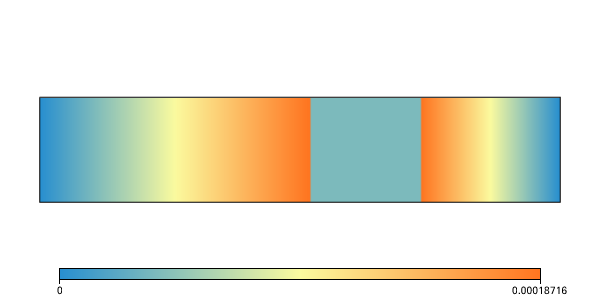

In [8]:
pIdFn = tm.plate_id_fn()
pAgeDict = tm.plate_age_fn() 

fnAge_map = fn.branching.map(fn_key = pIdFn , 
                          mapping = pAgeDict )

fig = glucifer.Figure(figsize=(600, 300))
fig.append( glucifer.objects.Surface(tm.mesh, fnAge_map ))
fig.show()

In [9]:
coordinate = fn.input()
depthFn = mesh.maxCoord[1] - coordinate[1]


platethickness = 2.32*fn.math.sqrt(1.*fnAge_map )  

halfSpaceTemp = npd.potentialTemp_*fn.math.erf((depthFn)/(2.*fn.math.sqrt(1.*fnAge_map)))


#this function encapsulates the plate part of the initial therma conditions (but not the slab)
plateTempFn = fn.branching.conditional( ((depthFn > platethickness, npd.potentialTemp_ ), 
                                           (True,                      halfSpaceTemp)  ))


## Make swarm and Slabs

In [10]:
swarm = uw.swarm.Swarm(mesh=mesh, particleEscape=True)
layout = uw.swarm.layouts.PerCellRandomLayout(swarm=swarm, particlesPerCell=int(20))
swarm.populate_using_layout( layout=layout ) # Now use it to populate.
proxyTempVariable = swarm.add_variable( dataType="double", count=1 )
proximityVariable      = swarm.add_variable( dataType="int", count=1 )
signedDistanceVariable = swarm.add_variable( dataType="double", count=1 )

#
proxyTempVariable.data[:] = 1.0
proximityVariable.data[:] = 0.0
signedDistanceVariable.data[:] = 0.0


In [11]:
#All of these wil be needed by the slab / fault setup functions
#We have two main options, bind them to the TectModel class. 
#or provide them to the functions
#collection them in a dictionary may be a useful way too proviede them to the fucntiosn 
#wthout blowing out the function arguments

tmUwMap = usub.tm_uw_map(temperatureField, velocityField, swarm, 
                    signedDistanceVariable, proxyTempVariable, proximityVariable)




In [12]:
#define fault particle spacing, here ~5 paricles per element
ds = (tm.maxX - tm.minX)/(5.*tm.mesh.elementRes[0])

efCollection = usub.interface_collection([])

#Make the fault thicker, so we see more
testThickness = 3*nmd.faultThickness
testFaultDepth = 3*nmd.faultThickness

def linearGradientFn(S, grad = -0.5):
    return grad
    




#This builds 1 embedded fault (interface2D) per subduction zone in the TectonicModel
#It also defines a distance field for the slab perturbation, which will be used to map to temperature
for e in tm.undirected.edges():
    if tm.is_subduction_boundary(e):
    
        usub.build_slab_distance(tm, e, linearGradientFn, nmd.slabInitMaxDepth, tmUwMap)
        sub_interface = usub.build_fault(tm, e, linearGradientFn, nmd.faultThickness , 
                                nmd.slabInitMaxDepth, ds, nmd.faultThickness, tmUwMap)
        efCollection.append(sub_interface)
        
        
#map the distance field for the slab perturbation, to a temperature structure:
#a halfspace profile, normal to the embedded fault
usub.build_slab_temp(tmUwMap, npd.potentialTemp_, nmd.slabAge)
fnJointTemp = fn.misc.min(proxyTempVariable, plateTempFn)


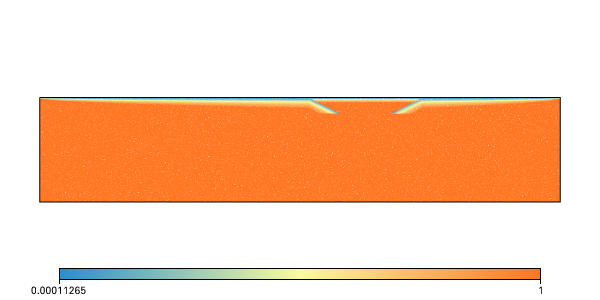

In [13]:
fig = glucifer.Figure(figsize=(600, 300))
fig.append( glucifer.objects.Points(swarm, fnJointTemp))
    

fig.show()
#fig.save_database('test.gldb')

##  Fault rebuild

In [14]:
# Setup a swarm to define the replacment positions

fThick= efCollection[0].thickness

faultloc = 1. - nmd.faultThickness*nmd.faultLocFac

allxs = np.arange(mesh.minCoord[0], mesh.maxCoord[0], ds )[:-1]
allys = (mesh.maxCoord[1] - fThick)*np.ones(allxs.shape)

faultMasterSwarm = uw.swarm.Swarm( mesh=mesh )
dummy =  faultMasterSwarm.add_particles_with_coordinates(np.column_stack((allxs, allys)))
del allxs
del allys

In [15]:
ridgedist = sca.non_dimensionalise(100e3*ur.meter)
subdist = sca.non_dimensionalise(150e3*ur.meter)


ridgeMaskFn = tm.ridge_mask_fn(ridgedist)
subMaskFn = tm.subduction_mask_fn(subdist)
boundMaskFn = tm.t2f(tm.combine_mask_fn(ridgeMaskFn , subMaskFn ))


In [17]:
dummy = usub.remove_faults_from_boundaries(tm, efCollection, ridgeMaskFn)
dummy = usub.remove_fault_drift(efCollection, faultloc)


In [22]:
#Deliberately remove some particles to test

f = efCollection[0]

with f.swarm.deform_swarm():
    mean = f.swarm.particleCoordinates.data[:,0].mean()
    mask = (f.swarm.particleCoordinates.data[:,0] < mean)
    with f.swarm.deform_swarm():
            f.swarm.particleCoordinates.data[mask] = (999999.,999999.)
           
# rebuild the KDtree

f.rebuild()

In [24]:
dummy = usub.pop_or_perish(tm, efCollection, faultMasterSwarm, boundMaskFn, ds)

In [25]:
#ds*2900.


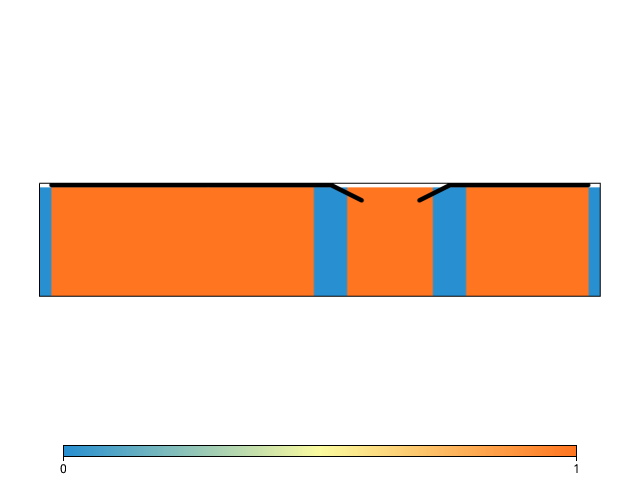

In [26]:
fig2 = glucifer.Figure()
#fig2.append( glucifer.objects.Points(swarm, fnJointTemp, pointSize=0.01))

for f in efCollection:
    fig2.append( glucifer.objects.Points(f.swarm, pointSize=5))

fig2.append( glucifer.objects.Surface(mesh, boundMaskFn ))

fig2.append( glucifer.objects.Points(faultMasterSwarm , pointSize=5, colour='white'))

fig2.show()
#fig2.save_database('test.gldb')

## Proximity



In [27]:
proximityVariable.data[:] = 0

In [28]:
for f in efCollection:
    f.rebuild()
    f.set_proximity_director(swarm, proximityVariable, searchFac = 2., locFac=1.0)

In [29]:
#fCollection[0].set_proximity_director(swarm, proximityVariable, locFac=1.)


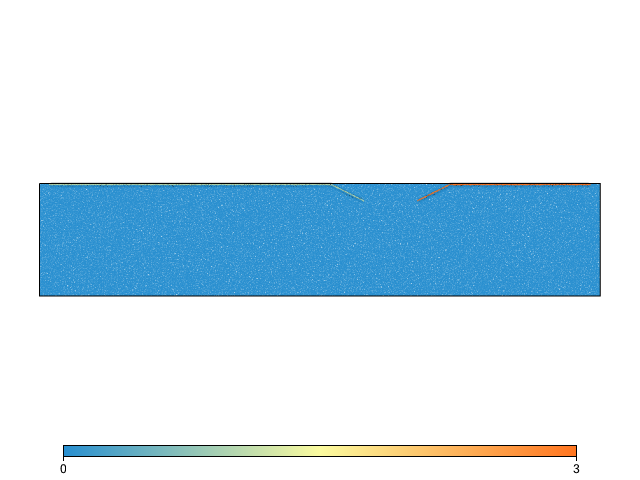

In [31]:
fig3 = glucifer.Figure()
#fig2.append( glucifer.objects.Points(swarm, fnJointTemp, pointSize=0.01))


fig3.append( glucifer.objects.Points(swarm , proximityVariable))

for f in efCollection:
    fig3.append( glucifer.objects.Points(f.swarm, pointSize=5))

fig3.show()
#fig3.save_database('test.gldb')